In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os

In [38]:
""""

We start off by reading all of the data into a pandas dataframe.
We're assuming all the csv files are in the /data directory.
We will create a dictionary that will hold the data from each file.
We will then iterate through each file, read the data using pandas read_csv, and append it to the dictionary.
Finally, we will create a pandas dataframe from the dictionary.


"""
# read the data, begin by getting a list of csv files in /data
data_dir = os.path.join(os.getcwd(), 'data')
data_files = os.listdir(data_dir)
data_files = [os.path.join(data_dir, file) for file in data_files]
# create a data dict that we will populate with data frome each file
data = {
    'file_name': [],
    'accelerometer' : [],
    'acoustic' : [],
    'speed' : [],
    'load' : [],
    'temperature_difference' : [],
    'bearing_id' : [],
    'condition_code' : [],
    'measurement_number' : []
}
# iterate through each file, read the data, and append it to the data dict
for file in data_files:
    data['file_name'].append(file)
    # use pandas to read the raw data from the csv file
    raw_data = pd.read_csv(file)
    # append the data to the data dict
    data['accelerometer'].append(raw_data['Accelerometer'].to_numpy())
    data['acoustic'].append(raw_data['Acoustic'].to_numpy())
    data['speed'].append(raw_data['Speed'].to_numpy().max())
    data['load'].append(raw_data['Load'].to_numpy().max())
    data['temperature_difference'].append(raw_data['Temperature Difference'].to_numpy())
    # get the bearing id from the file name
    data['bearing_id'].append(int(file.split('\\')[-1].split('.')[0].split('_')[1]))
    # get the condition code from the file name
    data['condition_code'].append(file.split('\\')[-1].split('.')[0].split('_')[0])
    # get the measurement number from the file name
    data['measurement_number'].append(int(file.split('\\')[-1].split('.')[0].split('_')[2]))
# create a dataframe from the data dict
df = pd.DataFrame(data)
# print the first 5 rows of the dataframe
df.head()

,file_name,accelerometer,acoustic,speed,load,temperature_difference,bearing_id,condition_code,measurement_number
0,c:\Users\Jacob\Documents\OpenPHM\Data from Mer...,"[-8.40605, -10.372236, -10.340004, -9.469725, ...","[0.029329, 0.025055, 0.023739, 0.025383, 0.027...",1709,0,"[11.980068, 13.599362, 13.120301, 13.093409, 1...",11,B,1
1,c:\Users\Jacob\Documents\OpenPHM\Data from Mer...,"[-193.614203, -185.330446, -144.717472, -75.83...","[-0.00322, -0.00585, -0.003877, -0.001576, -0....",1709,0,"[28.940376, 28.112346, 27.339743, 28.593982, 2...",11,B,2
2,c:\Users\Jacob\Documents\OpenPHM\Data from Mer...,"[20.538803, 12.996379, 1.908373, -7.987026, -1...","[0.009931, 0.009931, 0.010589, 0.010589, 0.011...",1720,0,"[18.351756, 16.741341, 17.227355, 17.543566, 1...",12,B,1
3,c:\Users\Jacob\Documents\OpenPHM\Data from Mer...,"[-6.40763, -15.658377, -25.618239, -41.831216,...","[-0.027878, -0.032481, -0.027878, -0.023933, -...",1720,0,"[33.574867, 32.009758, 33.115164, 31.866586, 3...",12,B,2
4,c:\Users\Jacob\Documents\OpenPHM\Data from Mer...,"[23.246341, 28.210159, 24.277783, 38.492355, 2...","[-0.004535, 0.001383, 0.001383, -0.009467, -0....",1725,0,"[11.836402, 10.378685, 10.207727, 11.016098, 1...",13,B,1


In [39]:
# It's easy to add columns for different things we might want to look at.

# add a column called 'acceleration_rms' to the dataframe, which is the root mean square of the acceleration array
df['acceleration_rms'] = df['accelerometer'].apply(lambda x: np.sqrt(np.mean(x**2)))
# add a column called 'acoustic_rms' to the dataframe, which is the root mean square of the acoustic array
df['acoustic_rms'] = df['acoustic'].apply(lambda x: np.sqrt(np.mean(x**2)))
# add acceleration std
df['acceleration_std'] = df['accelerometer'].apply(lambda x: np.std(x))
# add acoustic std
df['acoustic_std'] = df['acoustic'].apply(lambda x: np.std(x))
# add acceleration_crest_factor
df['acceleration_crest_factor'] = df['accelerometer'].apply(lambda x: np.max(np.abs(x)) / np.sqrt(np.mean(x**2)))
# add acoustic_crest_factor
df['acoustic_crest_factor'] = df['acoustic'].apply(lambda x: np.max(np.abs(x)) / np.sqrt(np.mean(x**2)))
# add acceleration_kurtosis
df['acceleration_kurtosis'] = df['accelerometer'].apply(lambda x: np.mean((x - np.mean(x))**4) / np.mean((x - np.mean(x))**2)**2)
# add acoustic_kurtosis
df['acoustic_kurtosis'] = df['acoustic'].apply(lambda x: np.mean((x - np.mean(x))**4) / np.mean((x - np.mean(x))**2)**2)
# add temperature_difference_mean
df['temperature_difference_mean'] = df['temperature_difference'].apply(lambda x: np.mean(x))
# add temperature_difference_max
df['temperature_difference_max'] = df['temperature_difference'].apply(lambda x: np.max(x))
# add temperature_difference_min_std
df['temperature_difference_min_std'] = df['temperature_difference'].apply(lambda x: np.std(x))
# print df head for just the added columns plus bearing id,  condition code, and measurement number
df[['bearing_id', 'condition_code', 'measurement_number', 'acceleration_rms', 'acoustic_rms', 'acceleration_std', 'acoustic_std', 'acceleration_crest_factor', 'acoustic_crest_factor', 'acceleration_kurtosis', 'acoustic_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'temperature_difference_min_std']].head()

,bearing_id,condition_code,measurement_number,acceleration_rms,acoustic_rms,acceleration_std,acoustic_std,acceleration_crest_factor,acoustic_crest_factor,acceleration_kurtosis,acoustic_kurtosis,temperature_difference_mean,temperature_difference_max,temperature_difference_min_std
0,11,B,1,32.796120,0.029616,32.647909,0.029601,11.968017,7.406876,13.297249,3.983374,12.409018,15.844929,0.816491
1,11,B,2,31.191498,0.028101,31.136711,0.028101,10.265816,5.150350,9.412941,3.444544,28.405821,31.610747,0.802812
2,12,B,1,14.989106,0.025998,14.672719,0.025672,6.751807,4.934562,4.023719,3.672299,17.429287,20.757221,0.716099
3,12,B,2,24.504464,0.026566,24.311606,0.026146,6.268045,4.940378,3.097190,3.701937,32.765171,35.665816,0.709433
4,13,B,1,43.754050,0.031670,43.740897,0.031612,6.847581,4.933152,3.853531,3.190203,11.568677,14.730428,0.732055


In [40]:
# added columns don't need to contain singular values, they can contain arrays as well
# let's add a column containing the frequency spectrum of the acceleration data
df['acceleration_spectrum'] = df['accelerometer'].apply(lambda x: np.abs(np.fft.fft(x))[1:int(0.5*len(np.abs(np.fft.fft(x))))])
# and a column containing the frequency spectrum of the acoustic data
df['acoustic_spectrum'] = df['acoustic'].apply(lambda x: np.abs(np.fft.fft(x))[1:int(0.5*len(np.abs(np.fft.fft(x))))])

In [41]:
# We can add columns that contain the rms, kurtosis, and standard deviatio of the acceleration and acoustic spectra
# add acceleration_spectrum_rms to the dataframe
df['acceleration_spectrum_rms'] = df['acceleration_spectrum'].apply(lambda x: np.sqrt(np.mean(x**2)))
# add acoustic_spectrum_rms to the dataframe
df['acoustic_spectrum_rms'] = df['acoustic_spectrum'].apply(lambda x: np.sqrt(np.mean(x**2)))
# add acceleration_spectrum_kurtosis to the dataframe
df['acceleration_spectrum_kurtosis'] = df['acceleration_spectrum'].apply(lambda x: np.mean((x - np.mean(x))**4) / np.mean((x - np.mean(x))**2)**2)
# add acoustic_spectrum_kurtosis to the dataframe
df['acoustic_spectrum_kurtosis'] = df['acoustic_spectrum'].apply(lambda x: np.mean((x - np.mean(x))**4) / np.mean((x - np.mean(x))**2)**2)
# add acceleration_spectrum_std to the dataframe
df['acceleration_spectrum_std'] = df['acceleration_spectrum'].apply(lambda x: np.std(x))
# add acoustic_spectrum_std to the dataframe
df['acoustic_spectrum_std'] = df['acoustic_spectrum'].apply(lambda x: np.std(x))
# print df head for just the added columns plus bearing id,  condition code, and measurement number

"""
There are some significant omissions from the frequency-domain features we've added.
We don't look at peak frequency, nor anything else that relates to fs
There's also no analysis of harmonics.
Some of these functions are available in the scipy.signal package
"""

df[['bearing_id', 'condition_code', 'measurement_number', 'acceleration_spectrum_rms', 'acoustic_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acoustic_spectrum_kurtosis', 'acceleration_spectrum_std', 'acoustic_spectrum_std']].head()

,bearing_id,condition_code,measurement_number,acceleration_spectrum_rms,acoustic_spectrum_rms,acceleration_spectrum_kurtosis,acoustic_spectrum_kurtosis,acceleration_spectrum_std,acoustic_spectrum_std
0,11,B,1,21158.313743,19.183373,212.293050,314.478397,20093.432604,18.672554
1,11,B,2,20178.942998,18.211274,228.380305,330.435482,19026.869896,17.670051
2,12,B,1,9509.031653,16.637338,223.238226,304.108683,9000.768268,16.389588
3,12,B,2,15755.758176,16.944902,254.575772,304.296497,14700.177535,16.522152
4,13,B,1,28347.407980,20.486758,184.227743,259.588682,25972.104451,19.479118


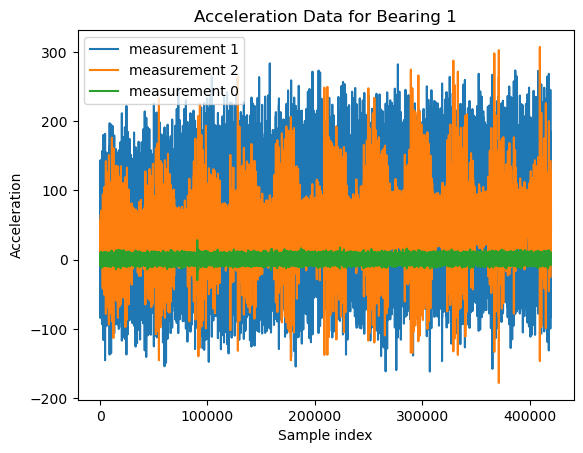

In [43]:
# For bearing id 1, plot acceleration data from measurement 1, 2, and 3 on the same plot
# get the data for bearing id 1
bearing_1 = df[df['bearing_id'] == 1]
# get the data for measurements 1, 2, and 3
measurement_1 = bearing_1[bearing_1['measurement_number'] == 0]
measurement_2 = bearing_1[bearing_1['measurement_number'] == 1]
measurement_3 = bearing_1[bearing_1['measurement_number'] == 2]
# plot the acceleration data for measurement 1, 2, and 3
plt.plot(measurement_2['accelerometer'].values[0])
plt.plot(measurement_3['accelerometer'].values[0])
plt.plot(measurement_1['accelerometer'].values[0])
# add a legend
plt.legend(['measurement 1', 'measurement 2', 'measurement 0'])
# add a title
plt.title('Acceleration Data for Bearing 1')
# add a label for the x axis
plt.xlabel('Sample index')
# add a label for the y axis
plt.ylabel('Acceleration')
# show the plot
plt.show()

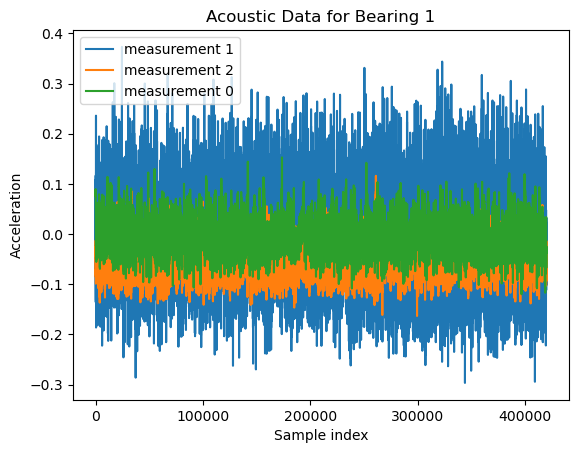

In [45]:
# For bearing id 1, plot acceleration data from measurement 1, 2, and 3 on the same plot
# get the data for bearing id 1
bearing_1 = df[df['bearing_id'] == 1]
# get the data for measurements 1, 2, and 3
measurement_1 = bearing_1[bearing_1['measurement_number'] == 0]
measurement_2 = bearing_1[bearing_1['measurement_number'] == 1]
measurement_3 = bearing_1[bearing_1['measurement_number'] == 2]
# plot the acceleration data for measurement 1, 2, and 3
plt.plot(measurement_2['acoustic'].values[0])
plt.plot(measurement_3['acoustic'].values[0])
plt.plot(measurement_1['acoustic'].values[0])
# add a legend
plt.legend(['measurement 1', 'measurement 2', 'measurement 0'])
# add a title
plt.title('Acoustic Data for Bearing 1')
# add a label for the x axis
plt.xlabel('Sample index')
# add a label for the y axis
plt.ylabel('Acceleration')
# show the plot
plt.show()

<Axes: xlabel='acceleration_kurtosis', ylabel='acoustic_kurtosis'>

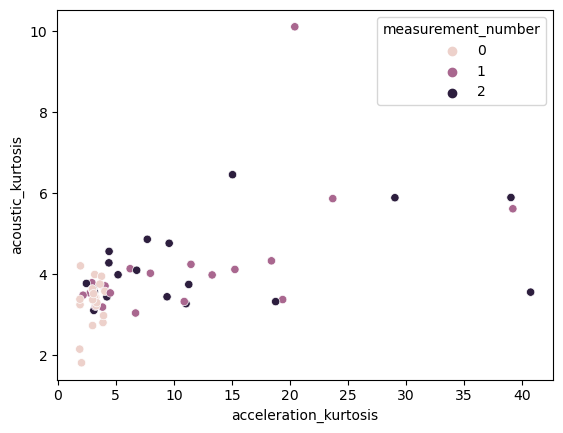

In [46]:
# create a scatter plot for the acceleration kurtosis and acoustic kurtosis with hue determined by measurement number
sns.scatterplot(data=df, x='acceleration_kurtosis', y='acoustic_kurtosis', hue='measurement_number')

"\nThis shows roughly how well the features we've used to fit the PCA model separate the different conditions.\n"

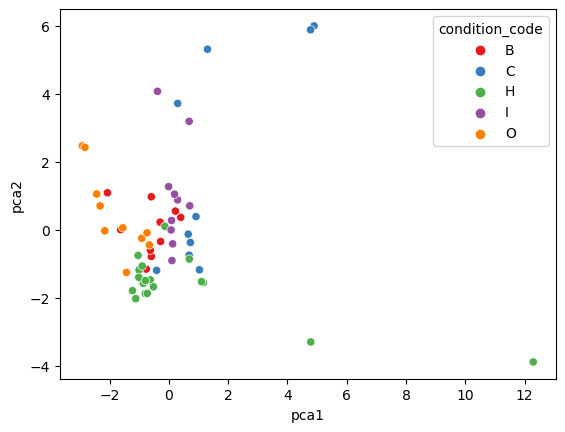

In [55]:
# let's use PCA to reduce the dimensionality of the data and then plot the data in 2D
# we'll use the whole df for this
# first, we need to scale the data
# create a scaler object
scaler = StandardScaler()
# fit the scaler to the data
scaler.fit(df[['acceleration_rms', 'acoustic_rms', 'acceleration_crest_factor', 'acoustic_crest_factor', 'acceleration_kurtosis', 'acoustic_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'acceleration_spectrum_rms', 'acoustic_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acoustic_spectrum_kurtosis', 'acceleration_spectrum_std', 'acoustic_spectrum_std']])
# transform the data
scaled_data = scaler.transform(df[['acceleration_rms', 'acoustic_rms', 'acceleration_crest_factor', 'acoustic_crest_factor', 'acceleration_kurtosis', 'acoustic_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'acceleration_spectrum_rms', 'acoustic_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acoustic_spectrum_kurtosis', 'acceleration_spectrum_std', 'acoustic_spectrum_std']])
# create a PCA object
pca = PCA(n_components=2)
# fit the PCA object to the scaled data
pca.fit(scaled_data)
# transform the scaled data
x_pca = pca.transform(scaled_data)
# add the two PCA components to the dataframe
df['pca1'] = x_pca[:,0]
df['pca2'] = x_pca[:,1]

# plot using sns.scatterplot
sns.scatterplot(data=df, x='pca1', y='pca2', hue='condition_code', palette = 'Set1')

"""
This shows roughly how well the features we've used to fit the PCA model separate the different conditions.
"""

<Axes: xlabel='pca1', ylabel='pca2'>

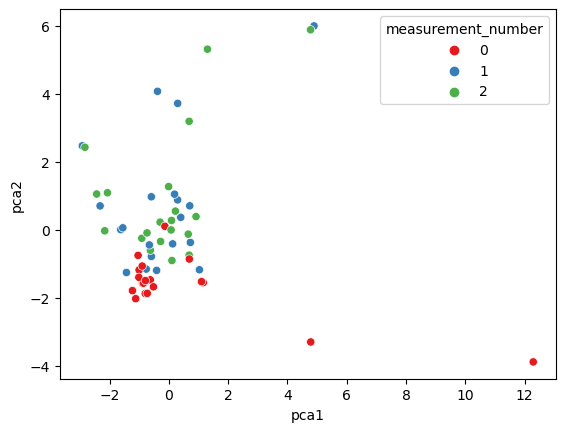

In [56]:
# We can also colour the points by measurement_number, which corresponds with health
sns.scatterplot(data=df, x='pca1', y='pca2', hue='measurement_number', palette='Set1')

<Axes: xlabel='pca1', ylabel='pca2'>

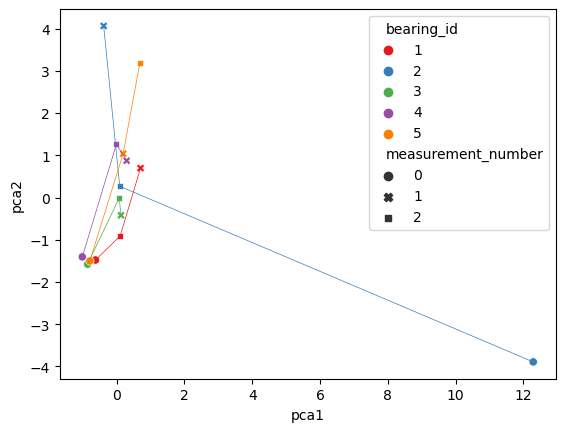

In [65]:
# lastly, let's colour by bearing_id, use a high contrast pallette and remove the legend, style points based on measurement number
# just doing a few bearings to make it easier to see
sns.scatterplot(data=df[df['bearing_id']<6], x='pca1', y='pca2', hue='bearing_id', palette='Set1', legend=True, style='measurement_number')
# add lines connecting points from the same bearing, using the same colour palette (makes it easier to see spread)
sns.lineplot(data=df[df['bearing_id']<6], x='pca1', y='pca2', hue='bearing_id', palette='Set1', legend=False, linewidth=0.5)
# this shows that bearing 2 starts sort of out in left field
# the general trend is that the rest begin clustered together and spread out as wear progresses

"""
Issue with lines - they connect points from left to right, not in order of measurement number
Could fix this by looping through the bearings and plotting each line segment separately
Just have to get the colours right...
"""

Mean accuracy score: 0.8304166666666667


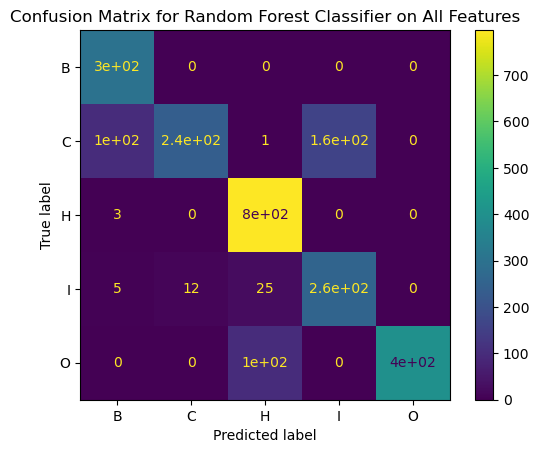

In [91]:
# train a random forest classifier on all the features (vibration, acoustic, temperature)
# create a new df keeping just the columns we want to use for the model
# this will be the columns with single-value features and the condition code (the target)
df_model = df[['condition_code', 'acceleration_rms', 'acoustic_rms', 'acceleration_crest_factor', 'acoustic_crest_factor', 'acceleration_kurtosis', 'acoustic_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'acceleration_spectrum_rms', 'acoustic_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acoustic_spectrum_kurtosis', 'acceleration_spectrum_std', 'acoustic_spectrum_std']]
accuracy_scores = []
cm_cumulative = np.zeros((5, 5)) # initialize a 5x5 matrix of zeros to hold the cumulative confusion matrix (important that this matches # of classes)
# loop through 100 random states for the train_test_split so we can get a mean accuracy score
for rand_state in range(1, 101):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_model.drop('condition_code', axis=1), df_model['condition_code'], test_size=0.4, random_state=3)
    # create a random forest classifier object
    rfc = RandomForestClassifier(n_estimators=200)
    # fit the model to the training data
    rfc.fit(X_train, y_train)
    # make predictions on the test data
    predictions = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
    cm_cumulative += cm
print(f'Mean accuracy score: {np.mean(accuracy_scores)}')
# we also take a sum of all the confusion matrices created at each step
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cumulative, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on All Features')
plt.show()

Mean accuracy score: 0.7495833333333334


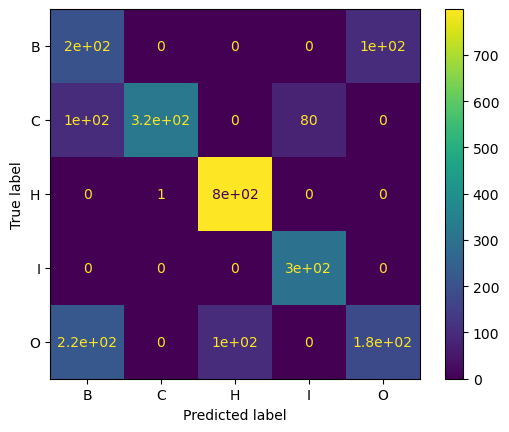

In [88]:
# train a random forest classifier on just the vibration features
# copy the df_model dataframe and drop the acoustic features
df_model_vibration = df_model.drop(['acoustic_rms', 'acoustic_crest_factor', 'acoustic_kurtosis', 'acoustic_spectrum_rms', 'acoustic_spectrum_kurtosis', 'acoustic_spectrum_std'], axis=1)
accuracy_scores = []
cm_cumulative = np.zeros((5, 5)) # initialize a 3x3 matrix of zeros to hold the cumulative confusion matrix
# loop through 100 random states for the train_test_split so we can get a mean accuracy score
for rand_state in range(1, 101):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_model_vibration.drop('condition_code', axis=1), df_model_vibration['condition_code'], test_size=0.4, random_state=3)
    # create a random forest classifier object
    rfc = RandomForestClassifier(n_estimators=200)
    # fit the model to the training data
    rfc.fit(X_train, y_train)
    # make predictions on the test data
    predictions = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
    cm_cumulative += cm
print(f'Mean accuracy score: {np.mean(accuracy_scores)}')
# we also take a sum of all the confusion matrices created at each step
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cumulative, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on Vibration Features')
plt.show()

Mean accuracy score: 0.4358333333333333


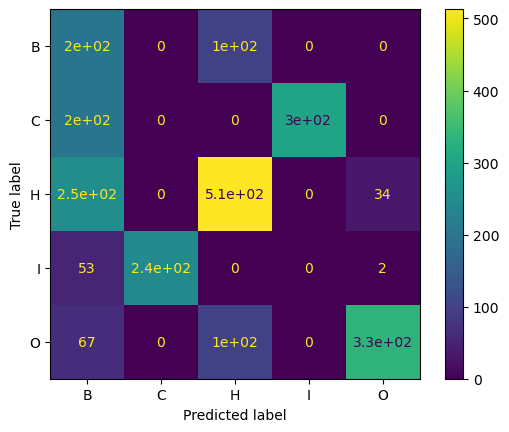

In [89]:
# train a random forest classifier on just the acoustic features
# copy the df_model dataframe and drop the vibration features
df_model_acoustic = df_model.drop(['acceleration_rms', 'acceleration_crest_factor', 'acceleration_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'acceleration_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acceleration_spectrum_std'], axis=1)
accuracy_scores = []
cm_cumulative = np.zeros((5, 5)) # initialize a 3x3 matrix of zeros to hold the cumulative confusion matrix
# loop through 100 random states for the train_test_split so we can get a mean accuracy score
for rand_state in range(1, 101):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_model_acoustic.drop('condition_code', axis=1), df_model_acoustic['condition_code'], test_size=0.4, random_state=3)
    # create a random forest classifier object
    rfc = RandomForestClassifier(n_estimators=200)
    # fit the model to the training data
    rfc.fit(X_train, y_train)
    # make predictions on the test data
    predictions = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
    cm_cumulative += cm
print(f'Mean accuracy score: {np.mean(accuracy_scores)}')
# we also take a sum of all the confusion matrices created at each step
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cumulative, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on acoustic Features')
plt.show()

Mean accuracy score: 0.8979166666666667


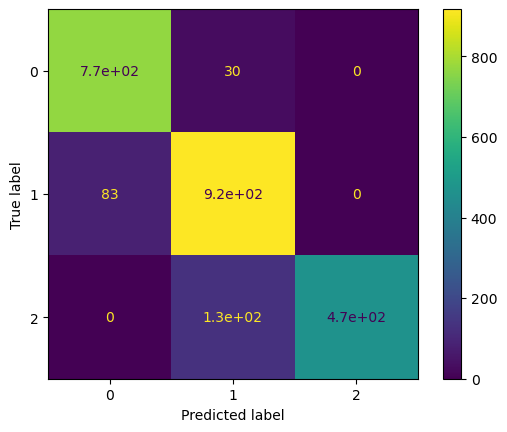

In [90]:
# let's train a model on all features but use measurement number as the target
# create a new df keeping just the columns we want to use for the model
# this will be the columns with single-value features and the measurement number (the target)
df_model = df[['measurement_number', 'acceleration_rms', 'acoustic_rms', 'acceleration_crest_factor', 'acoustic_crest_factor', 'acceleration_kurtosis', 'acoustic_kurtosis', 'temperature_difference_mean', 'temperature_difference_max', 'acceleration_spectrum_rms', 'acoustic_spectrum_rms', 'acceleration_spectrum_kurtosis', 'acoustic_spectrum_kurtosis', 'acceleration_spectrum_std', 'acoustic_spectrum_std']]
accuracy_scores = [] # initialize an empty list to hold the accuracy scores
cm_cumulative = np.zeros((3, 3)) # initialize a 3x3 matrix of zeros to hold the cumulative confusion matrix
# loop through 100 random states for the train_test_split so we can get a mean accuracy score
for rand_state in range(1, 101):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_model.drop('measurement_number', axis=1), df_model['measurement_number'], test_size=0.4, random_state=3)
    # create a random forest classifier object
    rfc = RandomForestClassifier(n_estimators=200)
    # fit the model to the training data
    rfc.fit(X_train, y_train)
    # make predictions on the test data
    predictions = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
    cm_cumulative += cm
print(f'Mean accuracy score: {np.mean(accuracy_scores)}')
# we also take a sum of all the confusion matrices created at each step
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cumulative, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier on All Features')
plt.show()